### Is Gun Violence in Boston Trending Up or Down?

It feels like gun violence in the USA is getting worse every year. I've had *multiple* conversations with friends abroad who are legitimately afraid to visit The States because of it. It's a weird thought to those of us who are from this country.

I've also covered the effects of gun violence in a short independent documentary that I produced that aired on PBS, which won a few awards at film festivals like RiverRun, IndieGrits, etc.

But what about my hometown, Boston? Massachusetts is supposed to be the safest state in terms of gun violence in the USA. That's good news for those of us who live here, but what direction are we trending? Are things getting worse or better?

**Let's find out**.

### The Data

I want to analyze two particular datasets here:

1. **Boston Police Department Shootings Data**
    - This data is well sourced and organized.
    - The city of Boston has a few problems, but data isn't one of them.
    - In fact, the Boston City Council just passed an ordinance in 2023 [requiring the BPD to track and report on all seized firearms](https://www.wbur.org/news/2023/11/15/boston-city-council-passes-measure-requiring-boston-police-to-track-seized-firearm-data), and the [data is already available and updated weekly](https://data.boston.gov/dataset/boston-police-department-firearm-recovery-counts).
    - Anyways, the data we are looking at is [here](https://data.boston.gov/dataset/shootings).

2. **NOAA Weather Data**
    - This data is also well sourced and organized.
    - In particular, I'm looking at Average Temperature and Precipitation from Logan International Airport.
    - This source has 100% coverage of every day from 2015-2023, whereas other sources don't.
    - We could attempt to compile data from a few stations that are *technically* in Boston, but this is much simpler and achieves the same result.
    - The data can be accessed [here](https://www.ncei.noaa.gov/cdo-web/).

### Examining The Data

Let's take a look at some of this shooting data. We'll import a few common python libraries, first.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Some Notes

We can see that this data includes some interesting details, including police district, victime gender, victim race, and weather multiple victims were involved.

It's also important to note that this data does not include self-inflicted gunshot wounds, or incidents where the shooting was determined to be justifiable.

Here, we're just looking only at illegal incidents.

In [2]:
# importing data
shootings = pd.read_csv('data/boston_shootings.csv')
shootings.head()

,incident_num,shooting_date,district,shooting_type_v2,victim_gender,victim_race,victim_ethnicity_NIBRS,multi_victim
0,I152000196-00,2015-01-01 13:30:00+00,C11,Non-Fatal,Male,Black or African American,Not Hispanic or Latinx,f
1,I152000879-00,2015-01-04 01:58:00+00,E18,Non-Fatal,Male,Black or African American,Not Hispanic or Latinx,f
2,I152001014-00,2015-01-04 18:52:00+00,E5,Non-Fatal,Male,Black or African American,Not Hispanic or Latinx,f
3,I152002232-00,2015-01-08 22:45:00+00,B2,Non-Fatal,Male,Black or African American,Not Hispanic or Latinx,t
4,I152002233-00,2015-01-08 22:45:00+00,B2,Non-Fatal,Female,Black or African American,Not Hispanic or Latinx,t


In [3]:
# cleaning up data

# converting the incident date to a pandas datetime object
shootings['shooting_date'] = pd.to_datetime(shootings['shooting_date'])
shootings['shooting_date'] = shootings['shooting_date'].dt.date
shootings['shooting_date'] = pd.to_datetime(shootings['shooting_date'])

### Tracking Incidents on the Weekly

I'd like to look at this data by week, but before we do that, let's add a new column filled with 1s. This way, when we groupby week, we can have a total count of the number of shootings that occurred that week.

In [4]:
# adding an incident_count column, one for each occurence
shootings['incident_count'] = 1

# grouping by day and sum only the incident_count column
shootings_daily = shootings.groupby(['shooting_date']).sum().reset_index()

In [5]:
# read in weather data in 3 parts because of limitations on the NOAA API
weather1 = pd.read_csv('data/bos_weather_2015_2017.csv')
weather2 = pd.read_csv('data/bos_weather_2018_2020.csv')
weather3 = pd.read_csv('data/bos_weather_2021_2023.csv')

weather = pd.concat([weather1, weather2, weather3])

# isolating the columns we want
weather = weather[['DATE', 'AWND', 'PRCP', 'SNOW', 'TAVG']]
weather['DATE'] = pd.to_datetime(weather['DATE'])

In [6]:
# merging the shootings data with the weather data

# adding the shootings data to the weather data
# we want to merge the shootings into the weather data
# because we want an entry for every single day, even if there were no shootings
weather = weather.merge(shootings_daily, left_on='DATE', right_on='shooting_date', how='left')

# dropping the shooting_date column now that we've merged
weather = weather.drop(columns=['shooting_date'])

# rewriting weather data to a new variable we'll use for now
shootings_daily = weather

# replacing NaNs with 0s in the incident_count column
shootings_daily['incident_count'] = shootings_daily['incident_count'].fillna(0)

# isolating the columns we want
shootings_daily = shootings_daily[['DATE', 'AWND', 'PRCP', 'TAVG', 'incident_count']]

In [7]:
# new dataframe which tracks incidents per week
shootings_weekly = shootings_daily.resample('W-Mon', on='DATE').sum().reset_index().sort_values(by='DATE')

shootings_weekly.head()

,DATE,AWND,PRCP,TAVG,incident_count
0,2015-01-05,67.79,1.19,166,3.0
1,2015-01-12,83.67,0.23,145,5.0
2,2015-01-19,80.52,0.27,189,2.0
3,2015-01-26,78.29,0.81,208,11.0
4,2015-02-02,102.91,1.85,144,0.0


### Visualizing the Data

I think it's fair to say that gun violence increases in the summer. This isn't a secret, nor has it ever been. But just to get an idea of what we're dealing with: 
- I've highlighted the summer weeks in red on this chart.
- The faded blue line is our raw data.
- The orange line is our data with a 5 week moving average applied.

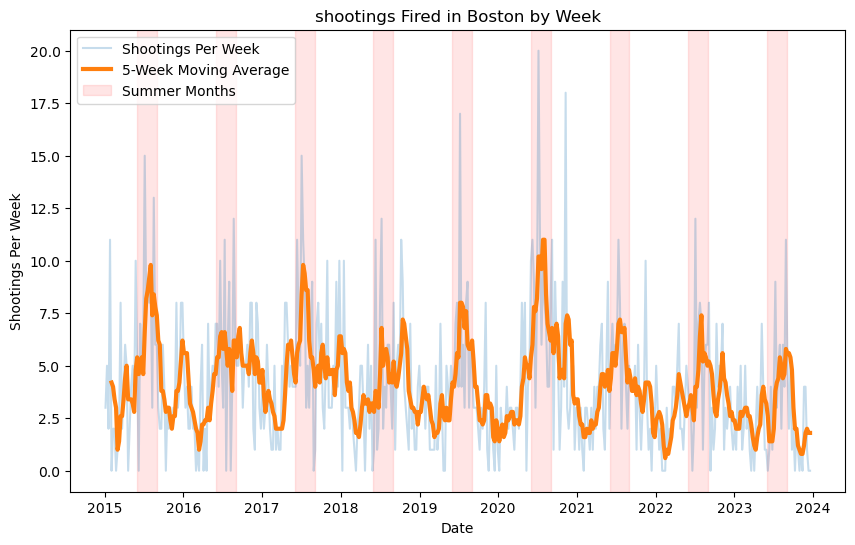

In [8]:
# adding a moving average to the plot with a thicker line
plt.figure(figsize=(10,6))
plt.plot(shootings_weekly['DATE'], shootings_weekly['incident_count'], alpha=0.25)
plt.plot(shootings_weekly['DATE'], shootings_weekly['incident_count'].rolling(5).mean(), linewidth=3)
plt.title('shootings Fired in Boston by Week')

# plotting the summer months in as vertical red bars
plt.axvspan('2015-06-01', '2015-09-01', color='red', alpha=0.1)
plt.axvspan('2016-06-01', '2016-09-01', color='red', alpha=0.1)
plt.axvspan('2017-06-01', '2017-09-01', color='red', alpha=0.1)
plt.axvspan('2018-06-01', '2018-09-01', color='red', alpha=0.1)
plt.axvspan('2019-06-01', '2019-09-01', color='red', alpha=0.1)
plt.axvspan('2020-06-01', '2020-09-01', color='red', alpha=0.1)
plt.axvspan('2021-06-01', '2021-09-01', color='red', alpha=0.1)
plt.axvspan('2022-06-01', '2022-09-01', color='red', alpha=0.1)
plt.axvspan('2023-06-01', '2023-09-01', color='red', alpha=0.1)

plt.legend(['Shootings Per Week', '5-Week Moving Average', 'Summer Months'])

plt.xlabel('Date')
plt.ylabel('Shootings Per Week')
plt.show()

### Calculating Hours of Daylight

As we move into summer months, two things happen: average temperature and hours of daylight increase. It's easy to see why this would result in an increase in shootings--people are out and about and more likely to cross paths with one another. Compare that to winter months where most people (including myself) would much rather be inside.

I wish I could tell you that I came up with the math for this function. But alas, I referred to Jake Vanderplaas and some help from GPT. I also verified the results by checking a few random dates and the recorded hours of daylight against this function.

In [9]:
# adding a function to calculate daylight hours
def hours_of_daylight(date, latitude=42.36):
    """Compute the hours of daylight for the given date"""
    # Constants
    axial_tilt = 23.44
    days_in_year = 365.25

    # Day of the year
    day_of_year = date.timetuple().tm_yday

    # Declination angle calculation
    declination = axial_tilt * np.sin(np.radians((360 / days_in_year) * (day_of_year - 81)))

    # Hour angle calculation
    hour_angle = np.arccos(-np.tan(np.radians(latitude)) * np.tan(np.radians(declination)))

    # Daylight hours calculation
    daylight_hours = 2 * np.degrees(hour_angle) / 15

    return daylight_hours

# Applying the function to each date in the DataFrame
shootings_weekly['daylight_hours'] = shootings_weekly['DATE'].apply(hours_of_daylight)

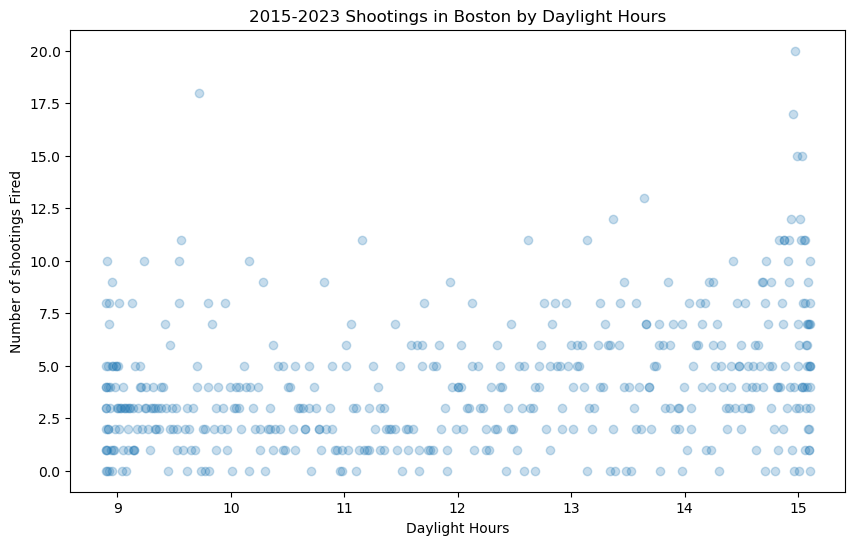

In [10]:
# plotting the number of shootings against the number of daylight hours
plt.figure(figsize=(10,6))
plt.scatter(shootings_weekly['daylight_hours'], shootings_weekly['incident_count'], alpha=0.25)
plt.title('2015-2023 Shootings in Boston by Daylight Hours')
plt.xlabel('Daylight Hours')
plt.ylabel('Number of shootings Fired')
plt.show()

### Accounting for Daylight

When we account for daylight, we can see that for every hour of daylight that's added, the number of shootings each week increases by 0.44. This isn't a major trend, but it shouldn't be ignored.

Model slope:     0.44408823159484234
Model intercept: -1.2440122524946755
R^2:             0.09445381707063394


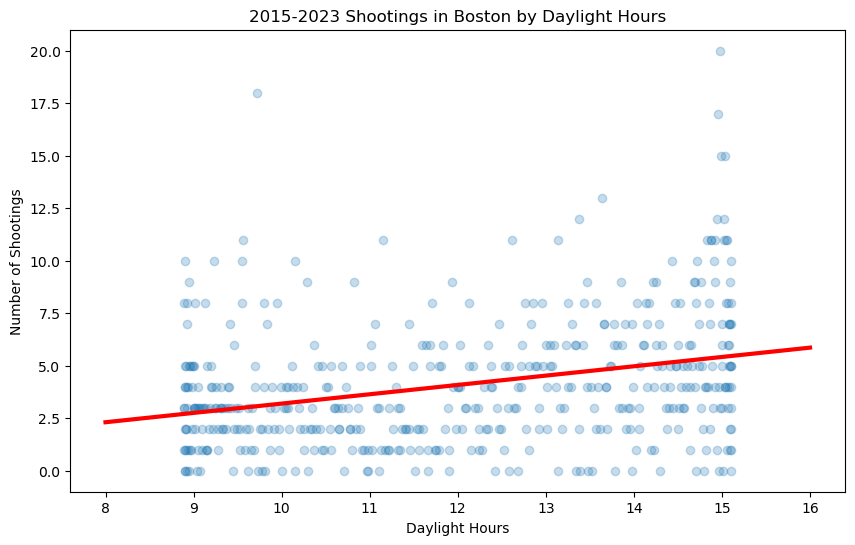

In [11]:
# modeling the relationship between daylight hours and shootings
from sklearn.linear_model import LinearRegression

X = shootings_weekly['daylight_hours'].values.reshape(-1, 1)
y = shootings_weekly['incident_count'].values.reshape(-1, 1)
reg = LinearRegression(fit_intercept=True).fit(X, y)

shootings_weekly['daylight_trend'] = reg.predict(X)
shootings_weekly['daylight_corrected_total'] = shootings_weekly['incident_count'] - shootings_weekly['daylight_trend'] + shootings_weekly['daylight_trend'].mean()

xfit = np.linspace(8, 16)
yfit = reg.predict(xfit[:, None])
plt.figure(figsize=(10,6))
plt.scatter(shootings_weekly['daylight_hours'], shootings_weekly['incident_count'], alpha=0.25)
plt.plot(xfit, yfit, linewidth=3, color='red')
plt.title("2015-2023 Shootings in Boston by Daylight Hours")
plt.xlabel('Daylight Hours')
plt.ylabel('Number of Shootings');

print("Model slope:    ", reg.coef_[0][0])
print("Model intercept:", reg.intercept_[0])
print("R^2:            ", reg.score(X, y))

### Detrending for Daylight

So let's create a model that accounts for Daylight, that is, let's create a model that tries to show how many shootings would occur if Daylight were not a factor.

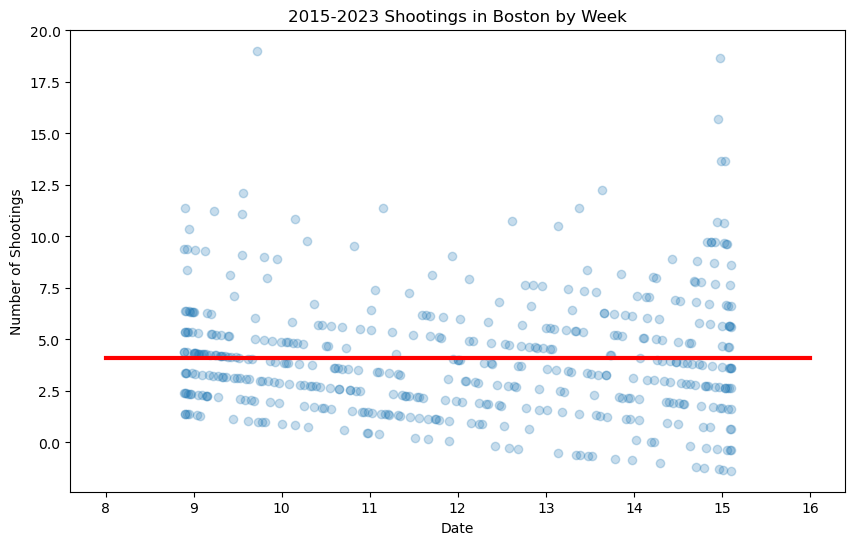

In [12]:
# detrending data by daylight hours
trend = reg.predict(shootings_weekly[['daylight_hours']].to_numpy())
shootings_weekly['detrended'] = shootings_weekly['incident_count'] - trend.flatten() + trend.mean()

# plotting the detrended data
plt.figure(figsize=(10,6))
plt.scatter(shootings_weekly['daylight_hours'], shootings_weekly['detrended'], alpha=0.25)
plt.plot(xfit, np.mean(trend) + 0 * yfit, linewidth=3, color='red')
plt.title('2015-2023 Shootings in Boston by Week')
plt.xlabel('Date')
plt.ylabel('Number of Shootings')
plt.show()

In [13]:
# reading in weather data in 3 parts because of limitations on the NOAA API data
weather1 = pd.read_csv('data/bos_weather_2015_2017.csv')
weather2 = pd.read_csv('data/bos_weather_2018_2020.csv')
weather3 = pd.read_csv('data/bos_weather_2021_2023.csv')

weather = pd.concat([weather1, weather2, weather3])

# isolating the columns we want
weather = weather[['DATE', 'AWND', 'PRCP', 'SNOW', 'TAVG']]
weather['DATE'] = pd.to_datetime(weather['DATE'])

# converting weather to a weekly dataframe
weather_weekly = weather.resample('W-Mon', on='DATE').mean().reset_index().sort_values(by='DATE')
weather_weekly = weather_weekly[['DATE', 'PRCP', 'TAVG']]

### Accounting for Average Temperature

Plotting average temperature is a little more compelling compared to daylight hours. Just by visualizing the data, we can see the trend starting to form. Let's apply Linear Regressions and see what results we get.

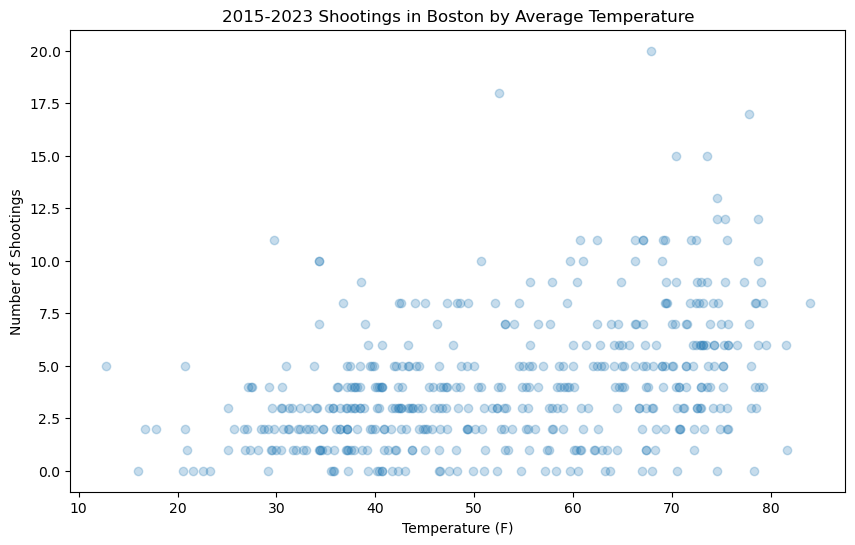

In [14]:
# plotting the number of shootings against the number of daylight hours
plt.figure(figsize=(10,6))
plt.scatter(weather_weekly['TAVG'], shootings_weekly['incident_count'], alpha=0.25)
plt.title('2015-2023 Shootings in Boston by Average Temperature')
plt.xlabel('Temperature (F)')
plt.ylabel('Number of Shootings')
plt.show()

### Accounting for Temperature

Interestingly (and scarily) is that for every degree the temperature goes up, the number of shootings goes up each week by 0.08. This means that for every 12.5 degrees the temperature increases, an additional incident should be expected that week.

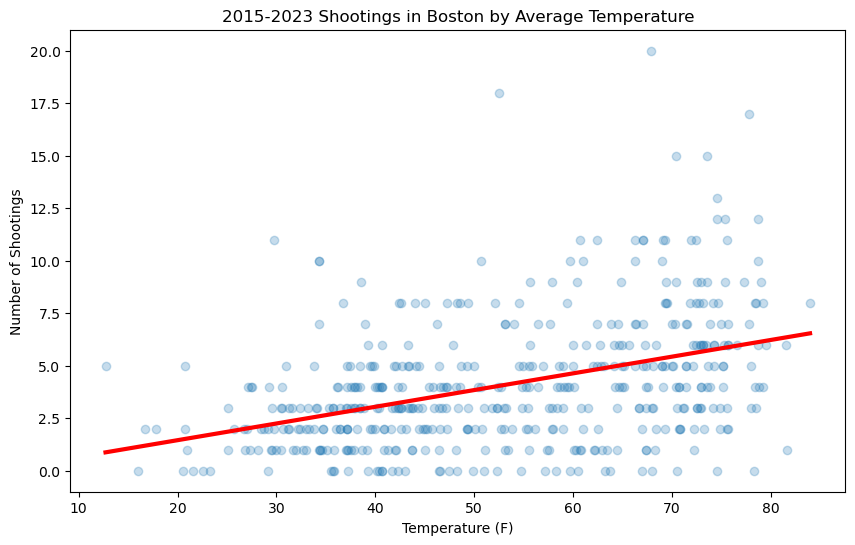

Model slope:     0.07951556216932602
Model intercept: -0.13653887974311818
R^2:             0.16982641070114823


In [16]:
# moving the temperature data to the shootings_weekly dataframe
shootings_weekly['TAVG'] = weather_weekly['TAVG']

# let's set the DATE column as the index
shootings_weekly = shootings_weekly.set_index('DATE')

# linear regression on the temperature data
from sklearn.linear_model import LinearRegression

X = shootings_weekly['TAVG'].values.reshape(-1, 1)
y = shootings_weekly['incident_count'].values.reshape(-1, 1)
reg = LinearRegression(fit_intercept=True).fit(X, y)

shootings_weekly['temp_trend'] = reg.predict(X)
shootings_weekly['temp_corrected_total'] = shootings_weekly['incident_count'] - shootings_weekly['temp_trend'] + shootings_weekly['temp_trend'].mean()

# Assuming other parts of your code are unchanged

# Use the actual range of temperature data for xfit
temp_min = shootings_weekly['TAVG'].min()
temp_max = shootings_weekly['TAVG'].max()
xfit = np.linspace(temp_min, temp_max, 100)  # Create 100 points for a smoother line

# Generate predictions for the xfit range
yfit = reg.predict(xfit[:, None])

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(shootings_weekly['TAVG'], shootings_weekly['incident_count'], alpha=0.25)
plt.plot(xfit, yfit, linewidth=3, color='red')
plt.title("2015-2023 Shootings in Boston by Average Temperature")
plt.xlabel('Temperature (F)')
plt.ylabel('Number of Shootings')
plt.show()

print("Model slope:    ", reg.coef_[0][0])
print("Model intercept:", reg.intercept_[0])
print("R^2:            ", reg.score(X, y))

# The Overall trend (temperature + daylight hours)

Now that we've looked at the trend for both temperature and daylight hours, we can create a model that takes both into account. We could do this to attempt to make predictions for weekly incident accounts, but here we'll be doing this so we can detrend our data and see which direction Boston is trending overall.

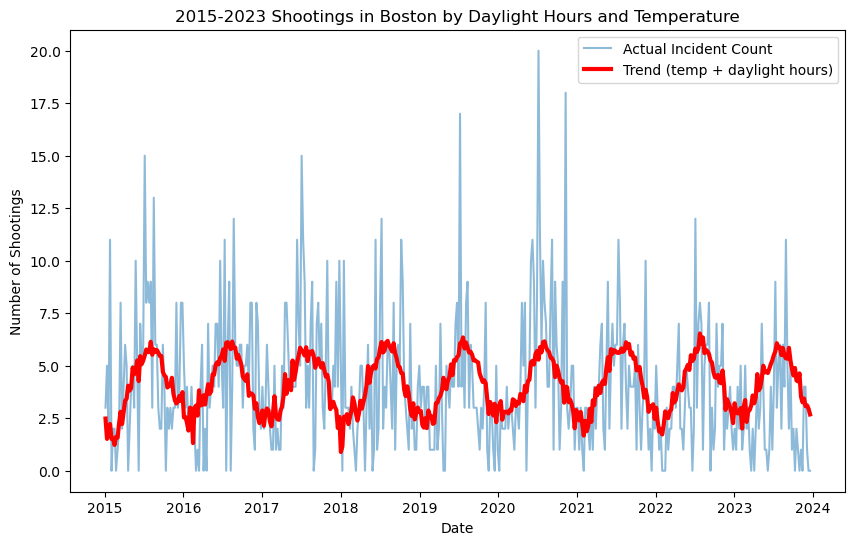

In [17]:
# Preparing X and y
X = shootings_weekly[['daylight_hours', 'TAVG']]
y = shootings_weekly['incident_count']

# Training
reg = LinearRegression().fit(X, y)

# Predicting
shootings_weekly['TAVG_daylight_trend'] = reg.predict(X)

# Plotting overall model fit
plt.figure(figsize=(10, 6))
plt.plot(shootings_weekly.index, shootings_weekly['incident_count'], 
         label='Actual Incident Count', alpha=0.5)
plt.plot(shootings_weekly.index, shootings_weekly['TAVG_daylight_trend'], 
         label='Trend (temp + daylight hours)', color='red', linewidth=3)
plt.title("2015-2023 Shootings in Boston by Daylight Hours and Temperature")
plt.xlabel('Date')
plt.ylabel('Number of Shootings')
plt.legend()
plt.show()

In [18]:
# checking in with our dataframe so far
shootings_weekly.head()

,AWND,PRCP,TAVG,incident_count,daylight_hours,daylight_trend,daylight_corrected_total,detrended,temp_trend,temp_corrected_total,TAVG_daylight_trend
DATE,,,,,,,,,,,
2015-01-05,67.79,1.19,33.200000,3.0,9.020912,2.762069,4.327675,4.327675,2.503378,4.586366,2.484089
2015-01-12,83.67,0.23,20.714286,5.0,9.157937,2.822920,6.266824,6.266824,1.510569,7.579174,1.516401
2015-01-19,80.52,0.27,27.000000,2.0,9.338895,2.903281,3.186462,3.186462,2.010381,4.079362,2.008196
2015-01-26,78.29,0.81,29.714286,11.0,9.558203,3.000673,12.089071,12.089071,2.226209,12.863534,2.223176
2015-02-02,102.91,1.85,20.571429,0.0,9.809899,3.112449,0.977295,0.977295,1.499210,2.590534,1.517375


### Precipitation and other factors

As seen below, precipitation data is not that compelling of an indicator. The coeffecient is quite negligable (0.142 increase in shootings for *each inch of rain*), as well as the R-squared score being quite low (2.698e-05).

For this reason, I think it's not worth considering this for now.

Since this is a *work in progress*, I'd like to add other relevant factors to this model and update it over time. If you have any suggestions, please feel free to contact me!

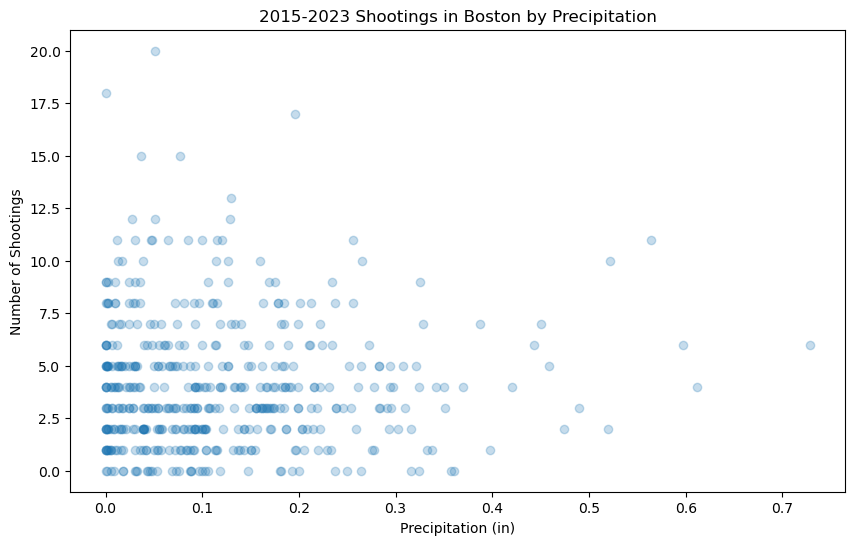

In [19]:
# plotting precipitation
plt.figure(figsize=(10,6))
plt.scatter(weather_weekly['PRCP'], shootings_weekly['incident_count'], alpha=0.25)
plt.title('2015-2023 Shootings in Boston by Precipitation')
plt.xlabel('Precipitation (in)')
plt.ylabel('Number of Shootings')
plt.show()

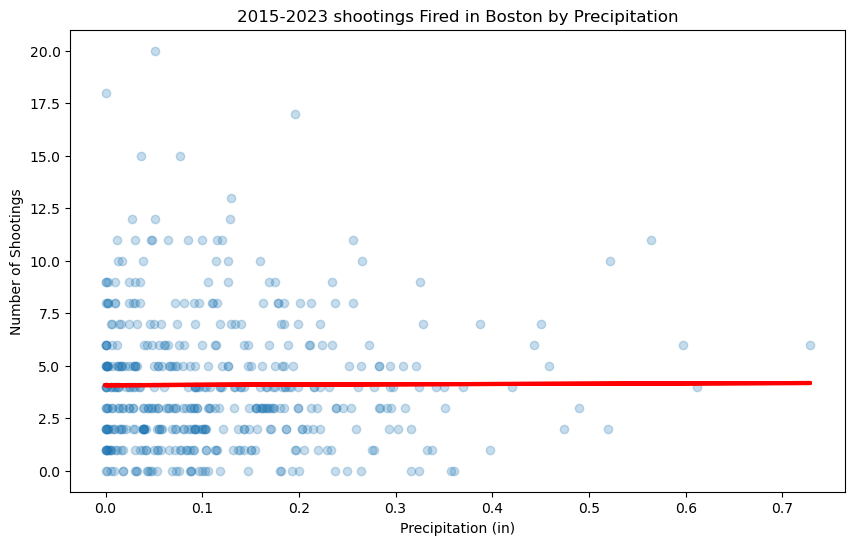

Coefficients: 
 [[0.14214701]]
Intercept: 
 [4.07310397]
R-squared: 
 2.6980461244940912e-05


In [20]:
# linear regression for precipitation

# we need to reshape the data for sklearn
precip = weather_weekly['PRCP'].values.reshape(-1, 1)
incident_count = shootings_weekly['incident_count'].values.reshape(-1, 1)

# creating the model
model = LinearRegression()
model.fit(precip, incident_count)

# let's plot the data and the line of best fit
plt.figure(figsize=(10,6))
plt.scatter(precip, incident_count, alpha=0.25)
plt.plot(precip, model.predict(precip), color='red', linewidth=3)
plt.title('2015-2023 shootings Fired in Boston by Precipitation')
plt.xlabel('Precipitation (in)')
plt.ylabel('Number of Shootings')
plt.show()

# let's print the coefficients
print('Coefficients: \n', model.coef_)
print('Intercept: \n', model.intercept_)
print('R-squared: \n', model.score(precip, incident_count))

### Final Detrended Data

Now we have our final detrended data. To clarify what we're looking at, this data doesn't show how many shootings are occuring each week, but rather it shows how many shootings are occuring this week *if temperature and daylight hours were not a factor*. Therefore, the spikes you're seeing are not necessarily a representation of spikes in gun violence, instead they are spikes in gun violence *based on what the model would expect*.

/Users/mark/anaconda3/envs/ds/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


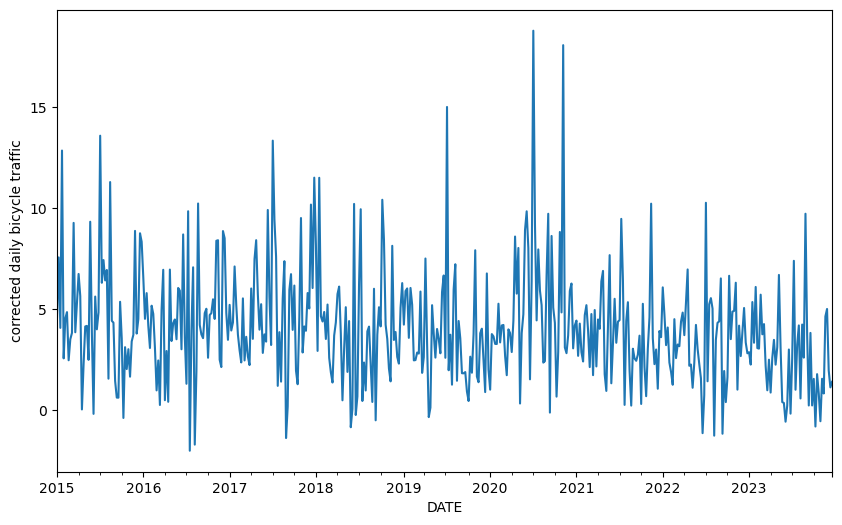

In [21]:
# let's detrend the data
trend = reg.predict(shootings_weekly[['daylight_hours', 'TAVG']].to_numpy())
shootings_weekly['all_detrended'] = shootings_weekly['incident_count'] - trend.flatten() + trend.mean()

# let's plot the detrended data
plt.figure(figsize=(10,6))
shootings_weekly['all_detrended'].plot()
plt.ylabel('corrected daily bicycle traffic');

### Smoothing The Data Out

Here, the data is smoothed out into a 30 week moving average so we can make some more sense of what we're seeing.

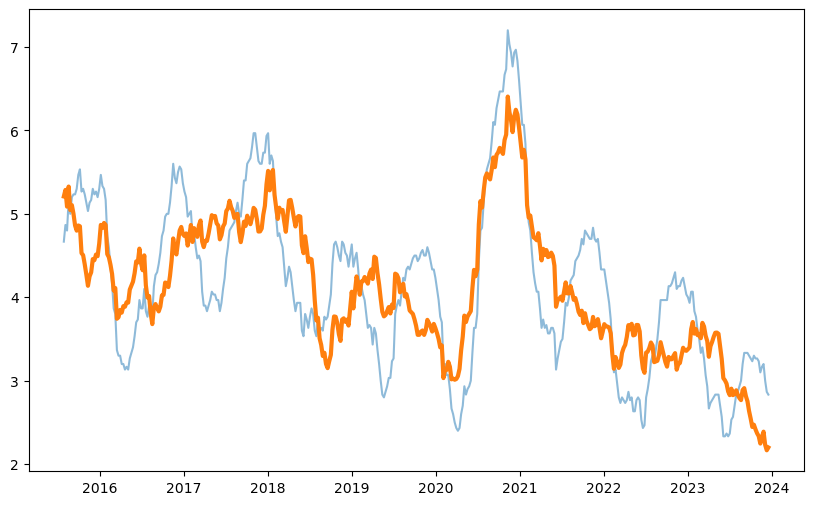

In [22]:
plt.figure(figsize=(10,6))
plt.plot(shootings_weekly['incident_count'].rolling(30).mean(), alpha=0.5)
plt.plot(shootings_weekly['all_detrended'].rolling(30).mean(), linewidth=3)

### Conclusions

Now that we have our detrended data, it's time plot a regression model (again) to see which direction Boston is trending. And it's good news, despite a **major** spike occuring during 2020 amidst the Covid-19 Pandemic, and detrending for weather and daylight, Boston is not only the capital of the best state in the USA in terms of gun violence, but it's *still* trending in the right direction.

Trend Coefficient: -0.0005706602520217025
Intercept: 5.022487771673062


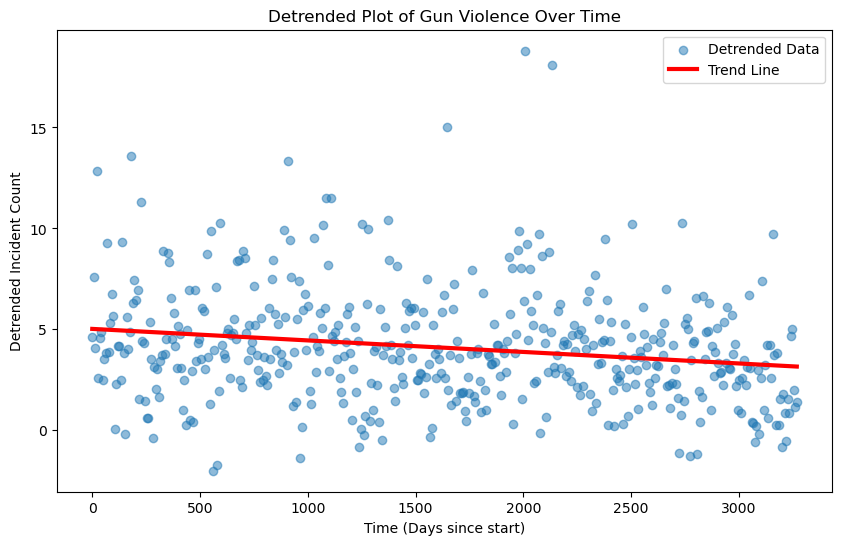

In [23]:
start_date = shootings_weekly.index.min()
shootings_weekly['time'] = (shootings_weekly.index - start_date).days

# Preparing X and y
X = shootings_weekly[['time']].values.reshape(-1, 1)  # Make sure it's in the right shape
y = shootings_weekly['all_detrended'].values

model = LinearRegression().fit(X, y)

print('Trend Coefficient:', model.coef_[0])
print('Intercept:', model.intercept_)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(shootings_weekly['time'], shootings_weekly['all_detrended'], label='Detrended Data', alpha=0.5)
plt.plot(shootings_weekly['time'], model.predict(X), color='red', linewidth=3, label='Trend Line')
plt.xlabel('Time (Days since start)')
plt.ylabel('Detrended Incident Count')
plt.title('Detrended Plot of Gun Violence Over Time')
plt.legend()
plt.show()